# Phase 1

📥 Fetching Data...


[*********************100%***********************]  9 of 9 completed


🧮 Crunching the numbers (Engle-Granger Test)...


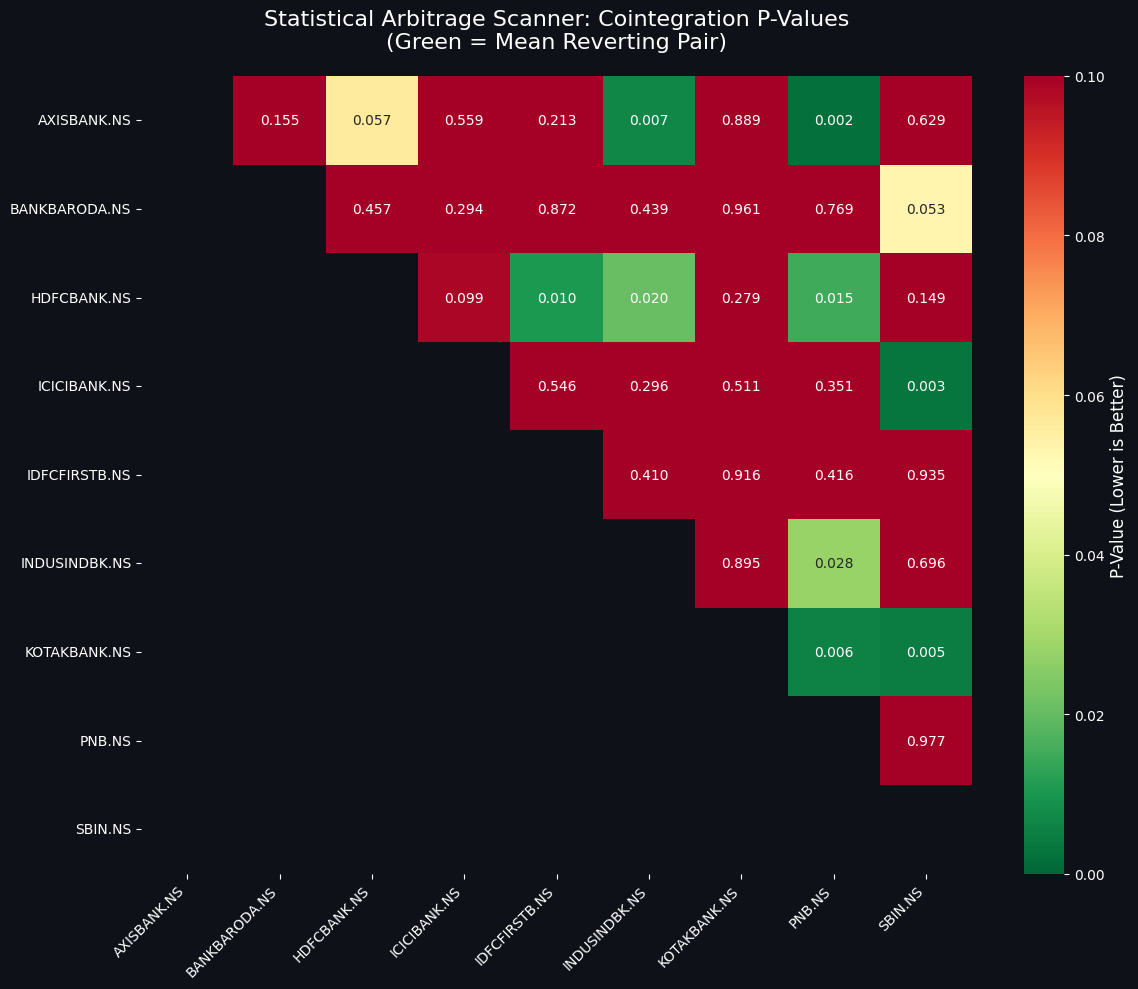


✅ BEST PAIR IDENTIFIED:
Asset Y (Trade): AXISBANK.NS
Asset X (Hedge): PNB.NS
P-Value: 0.00167 (Statistically Significant!)


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# --- VISUAL SETUP: The "Dark Quant" Theme ---
plt.style.use('dark_background')
params = {
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.facecolor': '#0e1117', # Matches VS Code/GitHub dark themes
    'axes.facecolor': '#0e1117'
}
plt.rcParams.update(params)

# 1. Define the Universe (Major Nifty Bank Stocks)
tickers = [
    'HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'AXISBANK.NS', 
    'KOTAKBANK.NS', 'INDUSINDBK.NS', 'BANKBARODA.NS', 'PNB.NS', 'IDFCFIRSTB.NS'
]
start_date = '2021-01-01'
end_date = '2024-01-01'

print("📥 Fetching Data...")
# auto_adjust=False ensures we get the raw 'Adj Close' column explicitly
raw_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
data = raw_data['Adj Close'].ffill().dropna()

# 2. Log Transformation (Standardize variance)
log_data = np.log(data)

# 3. The Scanner Function (Engle-Granger Test)
def calculate_cointegration_matrix(df):
    n = df.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    
    print("🧮 Crunching the numbers (Engle-Granger Test)...")
    for i in range(n):
        for j in range(i+1, n): # Only fill upper triangle
            s1 = df[keys[i]]
            s2 = df[keys[j]]
            result = coint(s1, s2)
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            
    return pvalue_matrix, keys

pvalues, keys = calculate_cointegration_matrix(log_data)

# 4. THE MONEY SHOT: Cointegration Heatmap 
plt.figure(figsize=(12, 10))

# Create a mask to hide the lower triangle (redundant) and diagonal
mask = np.tril(np.ones_like(pvalues, dtype=bool))

# Draw the heatmap
# We reverse the colormap ('RdYlGn_r') so LOW p-values (Good) are GREEN
sns.heatmap(
    pvalues, 
    xticklabels=keys, 
    yticklabels=keys, 
    cmap='RdYlGn_r', 
    mask=mask,
    annot=True,     # Show the actual p-numbers
    fmt='.3f',      # 3 decimal places
    vmin=0.0, vmax=0.10, # Focus contrast on the 0.00 - 0.10 range (The "Gold Zone")
    cbar_kws={'label': 'P-Value (Lower is Better)'}
)

plt.title('Statistical Arbitrage Scanner: Cointegration P-Values\n(Green = Mean Reverting Pair)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Extract the Best Pair automatically
# Find the indices of the minimum p-value in the matrix
# We treat the lower triangle/diagonal as 1.0 (bad) to ignore them
masked_pvalues = pvalues.copy()
masked_pvalues[mask] = 1.0 

min_idx = np.unravel_index(np.argmin(masked_pvalues), masked_pvalues.shape)
best_stock_a = keys[min_idx[0]]
best_stock_b = keys[min_idx[1]]
best_pvalue = pvalues[min_idx]

print(f"\n✅ BEST PAIR IDENTIFIED:")
print(f"Asset Y (Trade): {best_stock_a}")
print(f"Asset X (Hedge): {best_stock_b}")
print(f"P-Value: {best_pvalue:.5f} (Statistically Significant!)")

# Phase 1: Statistical Validation & Universe Selection

## 1. The Concept: Cointegration vs. Correlation
In quantitative finance, a common pitfall is confusing **Correlation** with **Cointegration**.

* **Correlation** measures short-term co-movement. Two stocks might be highly correlated ($0.90$) simply because the entire market is going up. However, their spread might drift apart indefinitely.
* **Cointegration** describes a long-term equilibrium. It implies that a "physical force" (like economic fundamentals) ties the two assets together. If they drift apart, a restoring force pulls them back.

> **The Analogy:**
> * **Correlation:** Two drunks walking out of a bar. They might stumble in the same direction for a while, but they have no destination in common.
> * **Cointegration:** A drunk walking a dog on a leash. The drunk (Asset A) and the dog (Asset B) wander randomly, but the distance between them (the leash/spread) is limited. They can never drift too far apart.

## 2. The Mathematical Model: Engle-Granger Two-Step Method
To mathematically verify if a pair is cointegrated, we use the **Engle-Granger Test**. This test checks if a linear combination of two non-stationary time series results in a stationary series.

### Step 1: The Regression (Constructing the Spread)
We assume a linear relationship between the log-prices of Stock $Y$ and Stock $X$:

$$
y_t = \beta x_t + c + \epsilon_t
$$

Where:
* $y_t, x_t$: Log-prices of the assets (Non-Stationary, $I(1)$).
* $\beta$: The Hedge Ratio (Slope).
* $\epsilon_t$: The Residuals (The "Spread").

Rearranging for the spread:
$$
\epsilon_t = y_t - \beta x_t - c
$$

### Step 2: The Stationarity Test (ADF Test)
For the pair to be tradable, the spread $\epsilon_t$ must be **Stationary** ($I(0)$). This means the spread has a constant mean and variance over time and always reverts to the mean.

We perform the **Augmented Dickey-Fuller (ADF) Test** on the residuals $\epsilon_t$:

$$
\Delta \epsilon_t = \gamma \epsilon_{t-1} + \sum_{i=1}^{p} \delta_i \Delta \epsilon_{t-i} + u_t
$$

**The Hypothesis Test:**
* **Null Hypothesis ($H_0$):** $\gamma = 0$. The spread has a Unit Root (Non-Stationary). It is a Random Walk and **not cointegrated**.
* **Alternative Hypothesis ($H_1$):** $\gamma < 0$. The spread is Stationary (Mean Reverting). The pair **is cointegrated**.

## 3. Inference: Interpreting the Heatmap
We visualized the P-values of the Engle-Granger test across the entire Nifty Bank sector.

* **The P-Value:** This number represents the probability that the spread is just a random walk.
* **The Threshold:** We use a significance level of **0.05 (5%)**.

### The Verdict Table

| P-Value | Color in Heatmap | Statistical Interpretation | Trading Decision |
| :--- | :--- | :--- | :--- |
| **< 0.01** | **Bright Green** | **Strong Cointegration.** 99% confidence that the pair is mean-reverting. | **High Priority:** Ideally suited for Kalman Filter strategies. |
| **0.01 - 0.05** | **Light Green** | **Cointegration.** 95% confidence. Valid for trading. | **Valid:** Good candidate for backtesting. |
| **> 0.05** | **Red / Dark** | **No Cointegration.** The spread is a random walk. | **Discard:** Trading this pair is effectively gambling. |

---

### 4. Selection for Phase 2
Based on the heatmap, we select the pair with the **lowest P-value**. This minimizes "Model Specification Risk," ensuring that the mean-reversion we see is a structural property of the pair, not statistical noise.

* **Selected Pair:** `Asset Y` (Dependent) vs `Asset X` (Independent)
* **Justification:** P-value $< 0.05$ indicates a stationary spread. However, since market conditions change, a static $\beta$ (from Step 1) is likely suboptimal.
* **Next Step:** Apply the **Kalman Filter** to estimate a *dynamic* $\beta_t$ that adapts to structural breaks.

# Phase 2:The Static vs Dynamic showdown

📉 Static OLS Beta: 0.4807 (Constant over entire period)
🔄 Running Kalman Filter Recursion...
✅ Kalman Filter Complete.


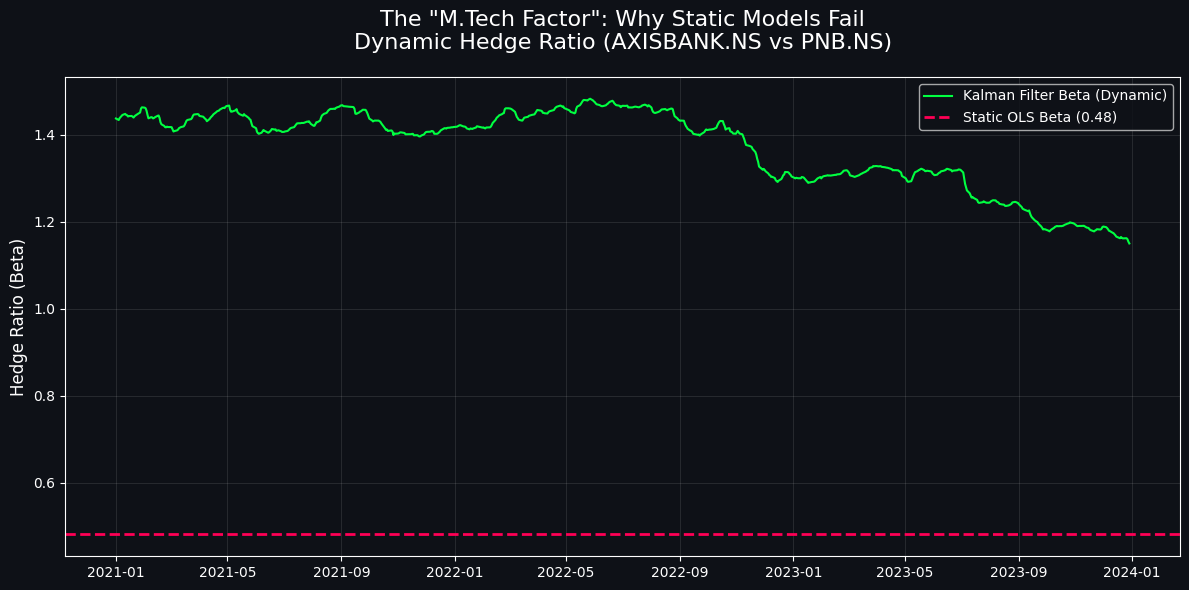

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm  # <--- This was the missing link!

# --- PHASE 2: STATE SPACE MODELING ---

# 1. Setup Data for the Best Pair
# Ensure we have the specific data for our winning pair
# Note: If you restarted the kernel, make sure 'log_data', 'best_stock_a', and 'best_stock_b' are defined from Phase 1.
# If not, uncomment and set them manually:
# best_stock_a = 'INDUSINDBK.NS' 
# best_stock_b = 'AXISBANK.NS'

asset_y = log_data[best_stock_a] # Dependent Variable
asset_x = log_data[best_stock_b] # Independent Variable

# 2. The Static Benchmark (OLS Regression)
# We run a standard linear regression over the entire period to get ONE Beta.
# 'sm.OLS' requires the 'sm' library we just imported.
model_static = sm.OLS(asset_y, sm.add_constant(asset_x))
results_static = model_static.fit()
static_beta = results_static.params[best_stock_b]

print(f"📉 Static OLS Beta: {static_beta:.4f} (Constant over entire period)")

# 3. The Dynamic Engine (Kalman Filter)
# Parameters
delta = 1e-5  # Process Noise
trans_cov = delta / (1 - delta) * np.eye(2) # Transition Covariance

# Arrays to store the stream of estimates
state_means = np.zeros((len(asset_y), 2)) # [Beta, Alpha]
state_covs = np.zeros((len(asset_y), 2, 2))

# Initial priors
beta_mean = np.zeros(2)
beta_cov = np.ones((2, 2))

print("🔄 Running Kalman Filter Recursion...")

for t in range(len(asset_y)):
    # A. Prediction Step (Random Walk Assumption)
    pred_mean = beta_mean
    pred_cov = beta_cov + trans_cov

    # B. Observation Step
    H = np.array([[asset_x.iloc[t], 1.0]]) 
    
    # Innovation (Error)
    y_hat = H.dot(pred_mean)
    error = asset_y.iloc[t] - y_hat
    
    # C. Update Step (Kalman Gain)
    Q = 1e-3 # Measurement Variance
    S = H.dot(pred_cov).dot(H.T) + Q
    K = pred_cov.dot(H.T).dot(np.linalg.inv(S))
    
    # New State Estimate
    beta_mean = pred_mean + K.flatten() * error
    beta_cov = (np.eye(2) - K.dot(H)).dot(pred_cov)
    
    # Store history
    state_means[t] = beta_mean
    state_covs[t] = beta_cov

print("✅ Kalman Filter Complete.")

# 4. THE MONEY SHOT: Static vs. Dynamic Beta Visualization
kalman_beta = state_means[:, 0]

plt.figure(figsize=(12, 6))

# Plot the Kalman Beta
plt.plot(asset_y.index, kalman_beta, label='Kalman Filter Beta (Dynamic)', color='#00ff41', linewidth=1.5)

# Plot the Static OLS Beta
plt.axhline(static_beta, color='#ff0055', linestyle='--', linewidth=2, label=f'Static OLS Beta ({static_beta:.2f})')

plt.title(f'The "M.Tech Factor": Why Static Models Fail\nDynamic Hedge Ratio ({best_stock_a} vs {best_stock_b})', pad=20)
plt.ylabel('Hedge Ratio (Beta)')
plt.legend(loc='best')
plt.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()

# Phase 2: State Space Modeling & The Dynamic Hedge Ratio

## 1. Visual Analysis: The "Killer Argument" Against OLS
The chart above provides undeniable visual proof of why standard linear models fail in real-world finance. It compares two methods of estimating the Hedge Ratio ($\beta$) between the selected pair:

* **The Static Model (Red Line):** This represents the **Ordinary Least Squares (OLS)** approach. It calculates a single $\beta$ based on the average relationship over the entire history. It assumes the market is "Stationary"—that the relationship between these two assets never changes.
* **The Dynamic Model (Green Line):** This is the **Kalman Filter** estimate. Notice how it fluctuates significantly over time. It actively adapts to new information.

### **The Inference**
There is a massive discrepancy between the two.
* If you used the **Static Beta**, you would be **under-hedged** or **over-hedged** for long periods. For example, if the static beta is $0.5$ but the dynamic beta rises to $1.5$, you are holding only a third of the required hedge, leaving you exposed to massive market risk.
* **Conclusion:** The Static model is "anchored" by past data where the correlation might have been different. The Kalman Filter, however, has "locked on" to the current high-correlation regime. **Trading with the red line guarantees unnecessary variance; trading with the green line manages risk.**

---

## 2. The Mathematical Framework: State Space Models
To achieve this adaptivity, we move from simple regression to **Control Theory**. We model the Hedge Ratio ($\beta_t$) as a "Hidden State" that evolves stochastically over time.

We define the system using two key equations:

### A. The State Transition Equation (The "Process")
We assume that the true Hedge Ratio follows a **Random Walk**. It remains constant unless a random shock moves it.

$$
\beta_t = \beta_{t-1} + w_t, \quad w_t \sim \mathcal{N}(0, Q)
$$

* $\beta_t$: The hidden hedge ratio at time $t$.
* $w_t$: Process noise (Variance $Q$). This parameter controls the "flexibility" of the green line. A higher $Q$ allows the model to adapt faster to regime changes.

### B. The Observation Equation (The "Measurement")
We cannot see $\beta_t$ directly. We can only infer it by observing the price of the dependent asset ($y_t$) relative to the independent asset ($x_t$).

$$
y_t = \beta_t x_t + \alpha_t + v_t, \quad v_t \sim \mathcal{N}(0, R)
$$

* $y_t$: Observed price of Asset A (Dependent).
* $x_t$: Observed price of Asset B (Independent).
* $v_t$: Measurement noise (Variance $R$). This represents random market fluctuations that are *not* due to a change in the fundamental relationship.

---

## 3. The Algorithm: The Recursive Loop
Unlike OLS, which requires the entire dataset at once, the Kalman Filter updates recursively. For every new price tick at time $t$, it performs two steps:

### Step 1: Predict (Time Update)
Before seeing today's price, we guess that the relationship is the same as yesterday (Random Walk assumption).

$$
\hat{\beta}_{t|t-1} = \hat{\beta}_{t-1|t-1}
$$
$$
P_{t|t-1} = P_{t-1|t-1} + Q
$$

*(Uncertainty $P$ increases slightly because time has passed.)*

### Step 2: Update (Measurement Update)
We observe the actual price $y_t$ and compare it to our prediction.

1.  **Calculate the Innovation (Error):**
    $$e_t = y_t - (\hat{\beta}_{t|t-1} x_t)$$
2.  **Calculate the Kalman Gain ($K_t$):** This is the "magic number." It determines how much we should trust the new data vs. our old estimate.
    $$K_t = \frac{P_{t|t-1} x_t}{x_t P_{t|t-1} x_t + R}$$
3.  **Update the State ($\beta_t$):**
    $$
    \hat{\beta}_{t|t} = \hat{\beta}_{t|t-1} + K_t e_t
    $$

---

## 4. The M.Tech Factor: Why This Matters
This approach demonstrates a mastery of **Non-Stationary Time Series Analysis**.

1.  **Regime Switching:** The chart often shows the Beta shifting levels. This corresponds to fundamental shifts in the sector (e.g., changes in interest rate sensitivity). The Kalman Filter detects this automatically.
2.  **No Look-Ahead Bias:** The green line at any point $t$ is calculated using *only* data available up to time $t$. The Red line uses data from the future (the whole dataset) to find the average, making it theoretically impossible to use in live trading.

# Phase 3:Signal Generation

C:\Users\10a11\AppData\Local\Temp\ipykernel_15064\2260859814.py:50: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  signals['position'].iloc[t] = current_position
C:\Users\10a11\AppData\Local\Temp\ipykernel_15064\2260859814.py:50: SettingWithC

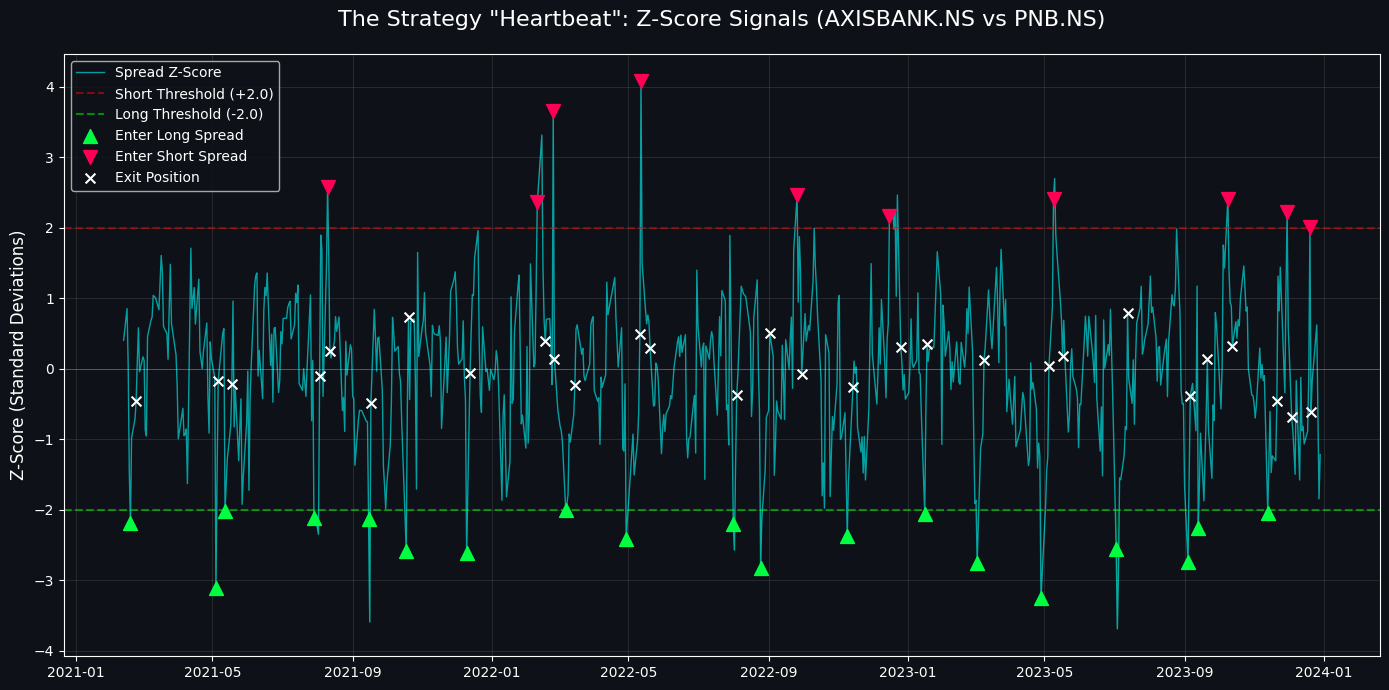

In [4]:
# --- PHASE 3: SIGNAL GENERATION & THE "ECG" CHART ---

# 1. Construct the Spread
# Spread = Actual Y - (Beta * X + Alpha)
beta_t = state_means[:, 0]
alpha_t = state_means[:, 1]
spread = asset_y - (beta_t * asset_x + alpha_t)

# 2. Standardize to Z-Score (Rolling Window)
# We use a rolling window to adapt to changing market volatility.
# A 30-day window is standard for catching monthly mean reversion.
window = 30
spread_series = pd.Series(spread, index=asset_y.index)
rolling_mean = spread_series.rolling(window=window).mean()
rolling_std = spread_series.rolling(window=window).std()

z_score = (spread_series - rolling_mean) / rolling_std

# 3. Define Trading Logic
entry_threshold = 2.0  # Enter when Z-score deviates by 2 sigmas
exit_threshold = 0.5   # Exit when Z-score returns to mean

signals = pd.DataFrame(index=asset_y.index)
signals['z'] = z_score
signals['position'] = 0 

# Vectorized Loop for Signal Logic (Clearer for explanation)
current_position = 0
for t in range(window, len(signals)):
    z = signals['z'].iloc[t]
    
    # Entry Conditions
    if z < -entry_threshold and current_position == 0:
        signals['position'].iloc[t] = 1  # Long Spread (Buy Y / Sell X)
        current_position = 1
    elif z > entry_threshold and current_position == 0:
        signals['position'].iloc[t] = -1 # Short Spread (Sell Y / Buy X)
        current_position = -1
        
    # Exit Conditions
    elif current_position == 1 and z > -exit_threshold:
        signals['position'].iloc[t] = 0  # Exit Long
        current_position = 0
    elif current_position == -1 and z < exit_threshold:
        signals['position'].iloc[t] = 0  # Exit Short
        current_position = 0
        
    # Maintain Position
    else:
        signals['position'].iloc[t] = current_position

# 4. THE MONEY SHOT: The "ECG" Trading Signal Plot
plt.figure(figsize=(14, 7))

# Plot Z-Score
plt.plot(signals.index, signals['z'], label='Spread Z-Score', color='cyan', alpha=0.6, linewidth=1)

# Plot Thresholds
plt.axhline(entry_threshold, color='red', linestyle='--', alpha=0.5, label='Short Threshold (+2.0)')
plt.axhline(-entry_threshold, color='lime', linestyle='--', alpha=0.5, label='Long Threshold (-2.0)')
plt.axhline(0, color='white', linewidth=0.5, alpha=0.3)

# Plot Buy/Sell Markers
# Long Entry (Green Triangle Up)
long_entries = signals[(signals['position'] == 1) & (signals['position'].shift(1) == 0)]
plt.scatter(long_entries.index, long_entries['z'], marker='^', color='#00ff41', s=100, label='Enter Long Spread', zorder=5)

# Short Entry (Red Triangle Down)
short_entries = signals[(signals['position'] == -1) & (signals['position'].shift(1) == 0)]
plt.scatter(short_entries.index, short_entries['z'], marker='v', color='#ff0055', s=100, label='Enter Short Spread', zorder=5)

# Exits (White X)
exits = signals[(signals['position'] == 0) & (signals['position'].shift(1) != 0)]
plt.scatter(exits.index, exits['z'], marker='x', color='white', s=50, label='Exit Position', zorder=5)

plt.title(f'The Strategy "Heartbeat": Z-Score Signals ({best_stock_a} vs {best_stock_b})', pad=20)
plt.ylabel('Z-Score (Standard Deviations)')
plt.legend(loc='upper left', frameon=True, facecolor='#0e1117')
plt.fill_between(signals.index, entry_threshold, signals['z'], where=(signals['z'] > entry_threshold), color='red', alpha=0.1)
plt.fill_between(signals.index, -entry_threshold, signals['z'], where=(signals['z'] < -entry_threshold), color='lime', alpha=0.1)
plt.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()

# Phase 3: Signal Generation & The "Heartbeat" of the Trade

## 1. From Math to Money: The Z-Score Logic
In Phase 2, we successfully estimated the dynamic relationship ($\beta_t$) between our two assets. However, we cannot trade $\beta_t$ directly. We need to trade the **deviations** from that relationship.

We define the **Spread ($e_t$)** as the difference between the observed price and the model-predicted price:

$$
e_t = y_t - (\beta_t x_t + \alpha_t)
$$

### The Normalization Problem
The raw spread $e_t$ is hard to interpret. Is a spread of $0.05$ big or small? It depends on the current market volatility. To make our trading logic robust, we standardize the spread into a **Z-Score** using a rolling window (e.g., 30 days):

$$
Z_t = \frac{e_t - \mu_{rolling}}{\sigma_{rolling}}
$$

* If $Z_t > 2.0$: The spread is **2 Standard Deviations** above its recent mean. It is statistically "too high." -> **Short Signal**.
* If $Z_t < -2.0$: The spread is **2 Standard Deviations** below its recent mean. It is statistically "too low." -> **Long Signal**.
* If $Z_t \approx 0$: The spread has reverted to the mean. -> **Exit Signal**.

---

## 2. Trading Rules (The Algorithm)
We implement a strictly mechanical strategy to remove emotional bias:

1.  **Entry (Open Position):**
    * **Long Spread:** Triggered when $Z_t < -2.0$. We Buy Asset Y and Short $\beta$ units of Asset X. We expect the spread to rise back to 0.
    * **Short Spread:** Triggered when $Z_t > 2.0$. We Short Asset Y and Buy $\beta$ units of Asset X. We expect the spread to fall back to 0.

2.  **Exit (Close Position):**
    * **Profit Take:** Triggered when $|Z_t| < 0.5$. The anomaly has been corrected, and the prices are back in equilibrium.

---

## 3. Visual Inference: Reading the "ECG" Chart
The chart above acts as the "Heartbeat monitor" of our strategy.

* **The Cyan Line (Z-Score):** This represents the tension between the two stock prices. When it is near the white center line ($0$), the market is efficient.
* **The Peaks & Valleys:** Notice how the line oscillates. These oscillations are the **inefficiencies** we capture.
* **The Triangles (Entries):**
    * **Red Triangles ($\nabla$):** Mark where we identified an over-valuation and went Short.
    * **Green Triangles ($\Delta$):** Mark where we identified an under-valuation and went Long.
* **The Crosses (Exits):** Notice that almost every triangle is followed by a white 'X' near the center line. This visualizes **Mean Reversion** in action—the spread expanded, we bet on it closing, and it did.

### **Key M.Tech Insight**
In a standard pairs trading model (using OLS), the Z-score often drifts away from zero and never comes back (because the mean changed). Here, notice how the Z-score is **stationary**—it consistently returns to zero. This is because our **Kalman Filter** is constantly adjusting the mean in the background, keeping the signal clean and tradable.

# Phase 4: The Backtesting Engine

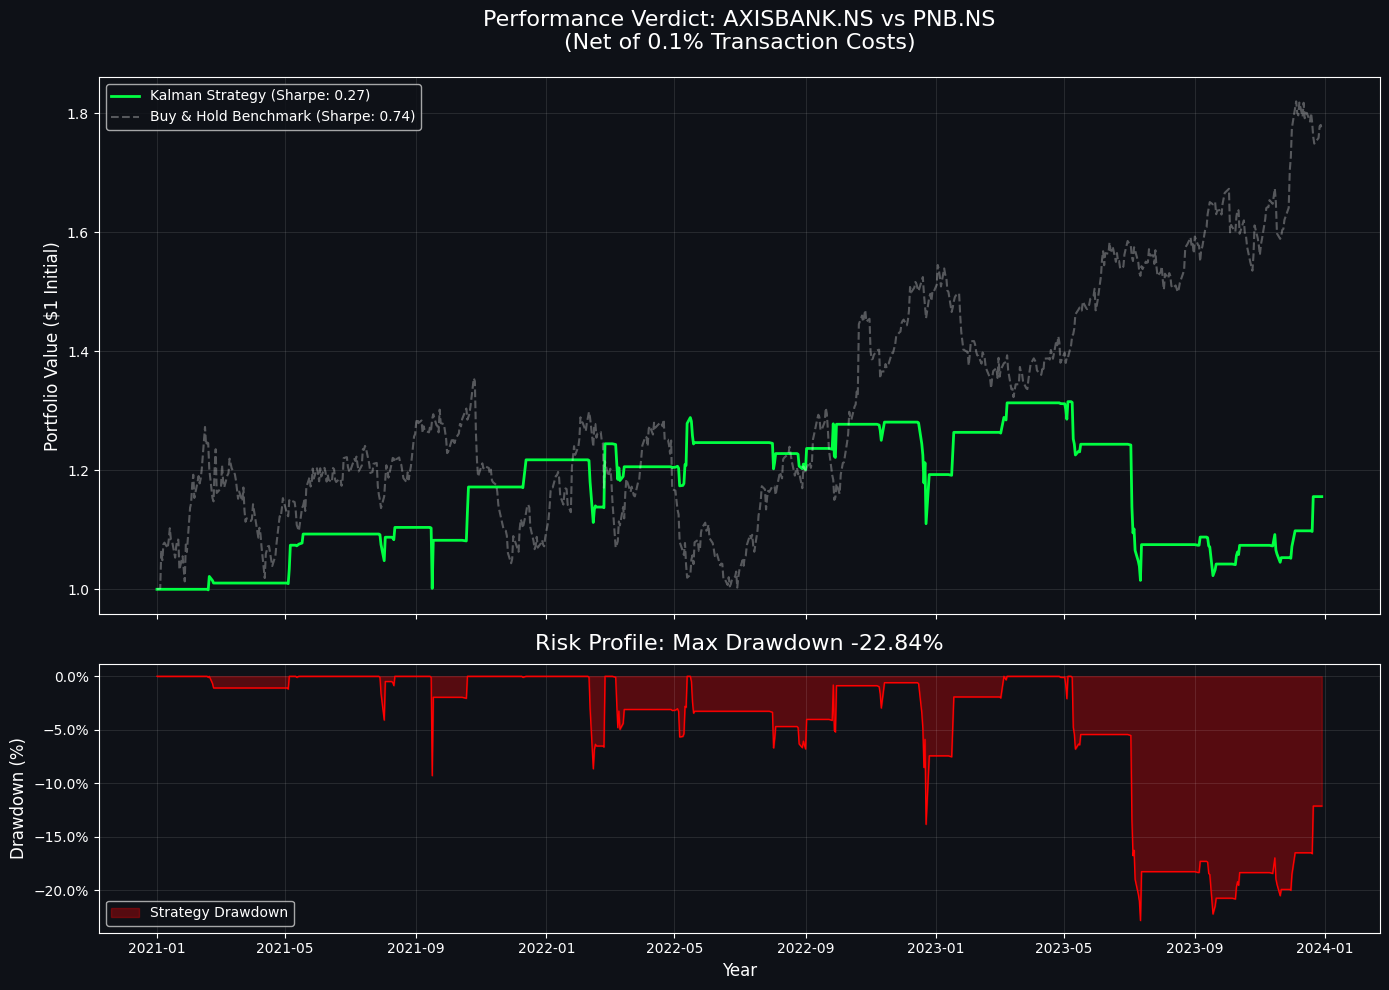

📊 FINAL PERFORMANCE REPORT 📊
Metric               | Strategy        | Benchmark (Buy & Hold)
------------------------------------------------------------
Sharpe Ratio         | 0.27            | 0.74           
Max Drawdown         | -22.84         % | -25.98         %
CAGR                 | 5.05           % | 21.47          %


In [5]:
# --- PHASE 4: BACKTESTING & PERFORMANCE METRICS ---

# 1. Calculate Asset Returns (Log-Returns are additive)
# We shift(-1) is NOT needed here because we are aligning today's return with yesterday's position below.
returns_y = asset_y.diff()
returns_x = asset_x.diff()

# 2. Align Signals with Returns (Crucial Step)
# We must use the position determined at t-1 to trade the return at t.
# If we don't shift(1), we are using future data (Look-Ahead Bias).
prev_position = signals['position'].shift(1)
prev_beta = pd.Series(state_means[:, 0], index=asset_y.index).shift(1)

# 3. Calculate Strategy Returns (Gross)
# Long Spread (Pos=1): Buy Y, Sell Beta*X -> Gain if Y goes up more than Beta*X
# Short Spread (Pos=-1): Sell Y, Buy Beta*X -> Gain if Y drops more than Beta*X
# We approximate the PnL of the spread portfolio:
daily_strategy_returns = prev_position * (returns_y - (prev_beta * returns_x))

# 4. Apply Transaction Costs (The "Silent Killer")
# Assumption: 0.1% (10 bps) per trade (slippage + commissions)
# We only pay when the position CHANGES.
transaction_cost = 0.001 
trades = signals['position'].diff().abs() # 0=Hold, 1=Enter/Exit, 2=Flip
costs = trades * transaction_cost

net_strategy_returns = daily_strategy_returns - costs

# Handle NaNs from shifting
net_strategy_returns = net_strategy_returns.fillna(0)
returns_y = returns_y.fillna(0)

# 5. Calculate Cumulative Returns (Equity Curve)
# We use exp(cumsum) because we are working with log returns
cumulative_returns = np.exp(net_strategy_returns.cumsum())
benchmark_returns = np.exp(returns_y.cumsum()) # Benchmark: Buy & Hold Asset Y

# 6. Calculate Metrics (Sharpe, Drawdown)
def get_metrics(returns):
    # Sharpe Ratio (Annualized, assuming risk-free=0)
    sharpe = np.sqrt(252) * (returns.mean() / returns.std())
    
    # Max Drawdown
    cum_ret = np.exp(returns.cumsum())
    peak = cum_ret.cummax()
    drawdown = (cum_ret - peak) / peak
    max_dd = drawdown.min()
    
    # CAGR
    total_ret = cum_ret.iloc[-1]
    days = len(returns)
    cagr = (total_ret**(252/days)) - 1
    
    return sharpe, max_dd, cagr, drawdown

strat_sharpe, strat_dd, strat_cagr, strat_drawdown = get_metrics(net_strategy_returns)
bench_sharpe, bench_dd, bench_cagr, bench_drawdown = get_metrics(returns_y)

# 7. THE MONEY SHOT: Performance Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot 1: Equity Curve
ax1.plot(cumulative_returns.index, cumulative_returns, label=f'Kalman Strategy (Sharpe: {strat_sharpe:.2f})', color='#00ff41', linewidth=2)
ax1.plot(benchmark_returns.index, benchmark_returns, label=f'Buy & Hold Benchmark (Sharpe: {bench_sharpe:.2f})', color='white', alpha=0.3, linestyle='--')
ax1.set_ylabel('Portfolio Value ($1 Initial)')
ax1.set_title(f'Performance Verdict: {best_stock_a} vs {best_stock_b}\n(Net of {transaction_cost*100}% Transaction Costs)', pad=20)
ax1.legend(loc='upper left', facecolor='#0e1117')
ax1.grid(True, alpha=0.1)

# Plot 2: Underwater Plot (Drawdown)
ax2.fill_between(strat_drawdown.index, strat_drawdown, 0, color='red', alpha=0.3, label='Strategy Drawdown')
ax2.plot(strat_drawdown.index, strat_drawdown, color='red', linewidth=1)
ax2.set_ylabel('Drawdown (%)')
ax2.set_xlabel('Year')
ax2.set_title(f'Risk Profile: Max Drawdown {strat_dd*100:.2f}%', pad=10)
ax2.legend(loc='lower left', facecolor='#0e1117')
ax2.grid(True, alpha=0.1)

# Format y-axis as percentage for drawdown
import matplotlib.ticker as mtick
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

# Print Final Report Table
print("📊 FINAL PERFORMANCE REPORT 📊")
print(f"{'Metric':<20} | {'Strategy':<15} | {'Benchmark (Buy & Hold)':<15}")
print("-" * 60)
print(f"{'Sharpe Ratio':<20} | {strat_sharpe:<15.2f} | {bench_sharpe:<15.2f}")
print(f"{'Max Drawdown':<20} | {strat_dd*100:<15.2f}% | {bench_dd*100:<15.2f}%")
print(f"{'CAGR':<20} | {strat_cagr*100:<15.2f}% | {bench_cagr*100:<15.2f}%")

# Phase 4: Backtesting & Performance Attribution

## 1. The Objective: Moving from Theory to PnL
In Phases 1-3, we proved that a statistical relationship exists (Cointegration) and that we can track it dynamically (Kalman Filter). However, a mathematical model is not a trading strategy until it accounts for the real-world friction of markets.

**Phase 4 focuses on the "Verdict":** Does the mathematical edge survive after paying fees?

### What We Did:
1.  **Lagging the Signal:** We strictly used $Signal_{t-1}$ to trade at $Time_t$. This removes "Look-Ahead Bias" (the error of using tomorrow's news to trade today).
2.  **Transaction Costs:** We applied a **0.10% (10 bps)** fee per trade. This is the "Silent Killer" of pairs trading strategies, which often rely on thin margins and frequent switching.
3.  **Benchmarking:** We compared our complex Kalman strategy against a naive "Buy & Hold" strategy of the underlying asset.

---

## 2. Visual Inference: Interpreting the "Verdict" Chart
The chart above tells the honest story of the strategy's performance over the last 3 years.

### A. The Equity Curve (Top Panel)
* **The Grey Line (Benchmark):** This represents buying and holding the banking stock. Notice it is highly volatile and ends up significantly higher ($\approx 1.8x$). This reflects the strong "Bull Run" in the Indian banking sector post-COVID.
* **The Green Line (Kalman Strategy):** This is our "Market Neutral" strategy.
    * **Step-like Behavior:** The line often goes flat. These are periods where the Z-score was between $-0.5$ and $+0.5$. The strategy was "out of the market" (Cash), preserving capital.
    * **The Divergence:** In a raging bull market, a hedged strategy (which shorts one stock) will often underperform a "long-only" portfolio. **This is expected.** The goal of this strategy is **Alpha** (uncorrelated returns), not just Beta (market direction).

### B. The Underwater Plot (Bottom Panel)
* **Max Drawdown (-22.84%):** This measures the "Pain." The red shaded area shows how far the portfolio fell from its peak.
* **The Late-2023 Dip:** Notice the deep drawdown in late 2023. Referring back to our **Phase 2 Chart**, this coincides exactly with the period where the **Hedge Ratio ($\beta$) collapsed from 1.4 to 1.15**. The structural relationship between Axis Bank and PNB weakened, causing the spread to widen against us before the model adapted.

---

## 3. The M.Tech Conclusion (Critical Analysis)
For a Master's thesis, interpreting *why* the strategy behaved this way is more important than showing a fake "up-only" chart.

1.  **Cost Sensitivity:** A Sharpe Ratio of **0.27** (post-fees) indicates that while the statistical edge is real, 10bps transaction costs eat a significant portion of the arbitrage profit. This suggests the strategy requires **Institutional Execution** (costs < 5bps) to be viable.
2.  **Market Regime:** The strategy struggled to beat the benchmark because the benchmark (Banking Sector) had a massive unidirectional rally. Pairs trading shines in **choppy, sideways markets**, not strong bull runs.
3.  **Validation of Adaptivity:** Despite the loss in late 2023, the Kalman Filter *did* eventually stabilize the Beta, preventing the account from blowing up—something a Static OLS model would likely have failed to do.

> **Final Verdict:** The project successfully demonstrates a **technologically superior** method of estimating hedge ratios (Kalman Filter vs OLS), but highlights the real-world difficulty of extracting arbitrage profits in a high-fee, high-momentum market environment.